# 프로젝트: 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

https://github.com/jpark9595/Ex_9_sentiment_classification/blob/master/Ex_9_sentiment_classification.ipynb

이전에 네이버 영화리뷰 감정분석 태스크를 다루어 본적이 있습니다.  
한국어로 된 corpus를 다루기 위하여 KoNLpy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리한뒤 RNN모델을 분류기로 사용했습니다.

이번에는 토크나이저를 sentencepiece로 바꾸어 이전과 성능을 비교해보는 작업을 해보도록 하겠습니다.

- 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

- 학습된 모델로 sp_tokenize() 메소드 구현하기

- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성늘 개선 여부 확인하기(Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.)

영화리뷰를 다시 다운받아 사용하도록하겠습니다

```bash
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sp_tokenizer/data
```

### 데이터 준비하기 & 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(len(train_data))
print(len(test_data))

150000
50000


### 데이터 전처리하기

중복된 데이터 제거 및 null값 제거하기

In [3]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any')

test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any')

In [4]:
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

False
False


In [5]:
print(len(train_data))
print(len(test_data))

146182
49157


## Step 1. SentencePiece 설치하기

$ pip install sentencepiece

## Step 2. SentencePiece 모델 학습

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

In [8]:
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel aiffel 376897 10월 29 17:36 korean_spm.model
-rw-r--r-- 1 aiffel aiffel 146388 10월 29 17:36 korean_spm.vocab


In [9]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

## Step 3. Tokenizer 함수 작성

In [10]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [11]:
train_tensor, train_word_index, train_index_word = sp_tokenize(s, train_data['document'])
test_tensor, test_word_index, test_index_word = sp_tokenize(s, test_data['document'])

In [12]:
train_index = train_data['label']
test_index = test_data['label']

## Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

### 모델 구성하기

In [13]:
from tensorflow import keras
word_vector_dim = 32

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                 input_shape=(None,)))
                                 
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 8)           264       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           9         
Total params: 264,593
Trainable params: 264,593
Non-trainable params: 0
_________________________________________________________________


In [14]:
# train set: validation settrain set을 약 4:1의 비율로 생성하겠다.
x_val = train_tensor[:30000]   
y_val = train_index[:30000]

partial_x_train = train_tensor[30000:]  
partial_y_train = train_index[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 140)
(116182,)


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
BATCH_SIZE = 1024
EPOCHS = 100
filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCHS, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )
earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=20,         # 20회 Epoch동안 개선되지 않는다면 종료
                             )

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# 콜백 정의
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=10,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpoint, earlystopping, reduceLR],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
113/114 [============================>.] - ETA: 0s - loss: 0.6312 - accuracy: 0.6603
Epoch 00001: val_loss improved from inf to 0.53884, saving model to checkpoint-epoch-100-batch-1024-trial-001.h5
114/114 [==============================] - 3s 23ms/step - loss: 0.6309 - accuracy: 0.6608 - val_loss: 0.5388 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 2/100
112/114 [============================>.] - ETA: 0s - loss: 0.4786 - accuracy: 0.7950
Epoch 00002: val_loss improved from 0.53884 to 0.44332, saving model to checkpoint-epoch-100-batch-1024-trial-001.h5
114/114 [==============================] - 2s 20ms/step - loss: 0.4783 - accuracy: 0.7952 - val_loss: 0.4433 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 3/100
112/114 [============================>.] - ETA: 0s - loss: 0.4389 - accuracy: 0.8085
Epoch 00003: val_loss improved from 0.44332 to 0.43572, saving model to checkpoint-epoch-100-batch-1024-trial-001.h5
114/114 [==============================] - 2s 22ms/step - loss: 0.4387 -

Epoch 27/100
112/114 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8690
Epoch 00027: val_loss did not improve from 0.40951
114/114 [==============================] - 2s 21ms/step - loss: 0.3023 - accuracy: 0.8689 - val_loss: 0.4282 - val_accuracy: 0.8156 - lr: 5.0000e-04
Epoch 28/100
112/114 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8705
Epoch 00028: val_loss did not improve from 0.40951
114/114 [==============================] - 2s 21ms/step - loss: 0.2993 - accuracy: 0.8705 - val_loss: 0.4535 - val_accuracy: 0.8161 - lr: 5.0000e-04
Epoch 29/100
113/114 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8730
Epoch 00029: val_loss did not improve from 0.40951
114/114 [==============================] - 3s 22ms/step - loss: 0.2955 - accuracy: 0.8730 - val_loss: 0.4571 - val_accuracy: 0.8143 - lr: 5.0000e-04
Epoch 30/100
111/114 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8748
Epoch 00

In [18]:
results = model.evaluate(test_tensor,  test_index, verbose=1)

print(results)

1537/1537 [==============================] - 4s 2ms/step - loss: 0.4562 - accuracy: 0.8102
[0.4561798572540283, 0.8102299571037292]


In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


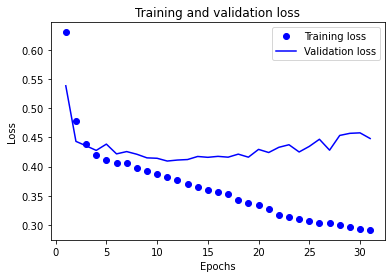

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

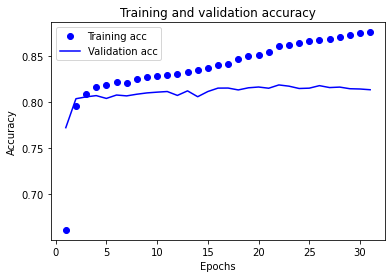

In [21]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 결과 및 분석

Ex_9에서 진행하였던 네이버 영화리뷰 감정 분석을 SentencePiece를 사용하여 분석해보았습니다.  
최종적으로 81%의 정확도를 얻었지만 다른 토크나이저와 비교를 해보았을때 많이 뛰어난 성능을 보이는 것 같지는 않습니다. 추후에 하이퍼파라미터를 변경하여 더 높은 성능을 낼수 있는지 확인해 보겠습니다. 